# **PHASE 1**: Data Integration

* Merge and clean data from five selected states.
* Standardize column structures, handle null values, and remove duplicates.
* Create a **canonical master dataset** combining data across all states to ensure
consistency and comparability.

## Importing Libraries

In [19]:
import pandas as pd
import os
import numpy as np

## Defining File Paths

In [20]:
file_paths = {
    'Maharashtra': '/content/Maharashtra.csv',
    'Gujarat': '/content/Gujarat.csv',
    'Delhi': '/content/Delhi.csv',
    'Tamil Nadu': '/content/TamilNadu.csv',
    'Karnataka': '/content/Karnataka.csv'
}

## Data Cleaning

In [21]:
def clean_mca_df(df, state_name):
    df = df.copy()

    # Standardize column names
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

    # Add state column
    df['state'] = state_name

    # Convert date field
    if 'date_of_incorporation' in df.columns:
        df['date_of_incorporation'] = pd.to_datetime(df['date_of_incorporation'], errors='coerce')

    # Strip whitespace from string columns
    str_cols = df.select_dtypes(include='object').columns
    df[str_cols] = df[str_cols].apply(lambda x: x.str.strip())

    # Drop duplicates based on CIN
    if 'cin' in df.columns:
        df = df.drop_duplicates(subset='cin')

    return df

## Loading and Cleaning States

In [22]:
dfs = []
for state, path in file_paths.items():
    if os.path.exists(path):
        print(f"Loading {state}...")
        df = pd.read_csv(path, encoding='ISO-8859-1', low_memory=False)
        df_clean = clean_mca_df(df, state)
        dfs.append(df_clean)
    else:
        print(f"File not found for {state}: {path}")

Loading Maharashtra...
Loading Gujarat...
Loading Delhi...
Loading Tamil Nadu...
Loading Karnataka...


## Merging Into One Canonical Dataset

In [23]:
master_df = pd.concat(dfs, ignore_index=True)
print(f"\nCombined dataset shape: {master_df.shape}")


Combined dataset shape: (1235113, 17)


In [24]:
master_df.to_csv('mca_master_dataset.csv', index=False)
print("Saved as 'mca_master_dataset.csv'")

Saved as 'mca_master_dataset.csv'


# **PHASE 2**: Change Detection

Design and implement a system to **detect and log company-level changes daily**.

The system should:
* Identify key change categories:
  * **New incorporations**
  * **Status changes**
  * **Authorized or Paid-up Capital modifications**
* Generate structured change logs in CSV/JSON format with the following fields:
  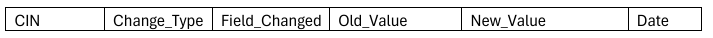

* Track updates across **three consecutive daily snapshots** to ensure temporal
accuracy.              
Date
* Maintain and automatically update a **master database** to reflect the most recent company information for each CIN.

## Loading Canonical Dataset

In [25]:
master_df = pd.read_csv('mca_master_dataset.csv')

/tmp/ipython-input-719140259.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  master_df = pd.read_csv('mca_master_dataset.csv')


In [26]:
master_df.head()

,cin,companyname,companyroccode,companycategory,companysubcategory,companyclass,authorizedcapital,paidupcapital,companyregistrationdate_date,registered_office_address,listingstatus,companystatus,companystatecode,companyindian/foreign_company,nic_code,companyindustrialclassification,state
0,U24299PN2019PTC181506,ANURIUSWELL PHARMACEUTICALS PRIAVTE LIMITED,ROC Pune,Company limited by shares,Non-government company,Private,100000.0,100000.0,2019-01-17,"54/2B, PLOT NO-24, GANESH TEMPLE ASHIRWAD PA...",Unlisted,Active,maharashtra,Indian,24299,"Manufacturing (Metals and Chemicals, and produ...",Maharashtra
1,U24299PN2019PTC187808,SKYI FKUR BIOPOLYMERS PRIVATE LIMITED,ROC Pune,Company limited by shares,Non-government company,Private,70000000.0,53300000.0,2019-11-16,PAP ï¿½x80x93S- 606364 MIDC CHAKAN INDUSTRIAL ...,Unlisted,Active,maharashtra,Indian,24299,"Manufacturing (Metals and Chemicals, and produ...",Maharashtra
2,U24299PN2020PTC192446,CHEMENGG RESEARCH PRIVATE LIMITED,ROC Pune,Company limited by shares,Non-government company,Private,100000.0,100000.0,2020-07-28,"GAT NO-90, BUILDING N-2, FLAT NO-408, RIVER ...",Unlisted,Active,maharashtra,Indian,24299,"Manufacturing (Metals and Chemicals, and produ...",Maharashtra
3,U24299PN2020PTC192728,VIDHI AYURVEDIC AND HERBAL PRIVATE LIMITED,ROC Pune,Company limited by shares,Non-government company,Private,100000.0,10000.0,2020-08-06,"F NO A 206 TAHA HEIGHTS NEAR PRANT OFFICE,RA...",Unlisted,Active,maharashtra,Indian,24299,"Manufacturing (Metals and Chemicals, and produ...",Maharashtra
4,U24299PN2021PTC202706,GOPADMA ORIGINS PRIVATE LIMITED,ROC Pune,Company limited by shares,Non-government company,Private,500000.0,100000.0,2021-07-17,"F. No. 5, S.No.18/45/2 Indraprasth Park Near...",Unlisted,Active,maharashtra,Indian,24299,"Manufacturing (Metals and Chemicals, and produ...",Maharashtra


## Simulating Daily Snapshots

In [27]:
# Day 1: Slightly incomplete
day1 = master_df.sample(frac=0.95, random_state=1)

# Day 2: Modify status and authorized capital
day2 = day1.copy()
day2.loc[day2.sample(5, random_state=2).index, 'companystatus'] = 'Strike Off'
day2.loc[day2.sample(5, random_state=3).index, 'authorizedcapital'] += 100000

# Day 3: Modify status and paid-up capital
day3 = day2.copy()
day3.loc[day3.sample(5, random_state=4).index, 'companystatus'] = 'Active'
day3.loc[day3.sample(5, random_state=5).index, 'paidupcapital'] += 50000

# Save snapshots
day1.to_csv('snapshot_day1.csv', index=False)
day2.to_csv('snapshot_day2.csv', index=False)
day3.to_csv('snapshot_day3.csv', index=False)


## Change Detection Function

In [28]:
def detect_changes(prev_df, curr_df, date_label):
    prev_df = prev_df.set_index('cin')
    curr_df = curr_df.set_index('cin')

    changes = []

    # New incorporations
    new_cins = curr_df.index.difference(prev_df.index)
    for cin in new_cins:
        changes.append({
            'CIN': cin,
            'Change_Type': 'New Incorporation',
            'Field_Changed': '-',
            'Old_Value': '-',
            'New_Value': '-',
            'Date': date_label
        })

    # Deregistrations
    removed_cins = prev_df.index.difference(curr_df.index)
    for cin in removed_cins:
        changes.append({
            'CIN': cin,
            'Change_Type': 'Deregistration',
            'Field_Changed': '-',
            'Old_Value': '-',
            'New_Value': '-',
            'Date': date_label
        })

    # Field-level updates
    common_cins = prev_df.index.intersection(curr_df.index)
    for cin in common_cins:
        prev_row = prev_df.loc[cin]
        curr_row = curr_df.loc[cin]
        for col in curr_df.columns:
            if col not in ['state'] and not pd.isna(prev_row[col]) and not pd.isna(curr_row[col]):
                if prev_row[col] != curr_row[col]:
                    changes.append({
                        'CIN': cin,
                        'Change_Type': 'Field Update',
                        'Field_Changed': col,
                        'Old_Value': prev_row[col],
                        'New_Value': curr_row[col],
                        'Date': date_label
                    })

    return pd.DataFrame(changes)

## Running Detection Across Snaphots

In [29]:
log_day2 = detect_changes(day1, day2, 'Day 2')
log_day3 = detect_changes(day2, day3, 'Day 3')

change_log = pd.concat([log_day2, log_day3], ignore_index=True)
change_log.to_csv('daily_change_log.csv', index=False)
print("Change log saved as 'daily_change_log.csv'")

Change log saved as 'daily_change_log.csv'


## Updating Master Dataset

In [30]:
day3.to_csv('mca_master_dataset_updated.csv', index=False)
print("Updated master dataset saved as 'mca_master_dataset_updated.csv'")

Updated master dataset saved as 'mca_master_dataset_updated.csv'


## Generating Markdown Summary

In [31]:
def generate_markdown_table(df, max_rows=10):
    header = "| CIN | Change_Type | Field_Changed | Old_Value | New_Value | Date |\n"
    divider = "|-----|--------------|----------------|-----------|-----------|------|\n"
    rows = ""
    for _, row in df.head(max_rows).iterrows():
        rows += f"| {row['CIN']} | {row['Change_Type']} | {row['Field_Changed']} | {row['Old_Value']} | {row['New_Value']} | {row['Date']} |\n"
    return header + divider + rows

markdown_summary = generate_markdown_table(change_log)
with open("change_log_summary.md", "w") as f:
    f.write(markdown_summary)
print("Markdown summary saved as 'change_log_summary.md'")

Markdown summary saved as 'change_log_summary.md'


## Generating HTML Table

In [32]:
def generate_html_table(df, max_rows=10):
    html = '<table border="1" cellspacing="0" cellpadding="5">\n<tr>'
    for col in df.columns:
        html += f"<th>{col}</th>"
    html += "</tr>\n"

    for _, row in df.head(max_rows).iterrows():
        html += "<tr>" + "".join(f"<td>{row[col]}</td>" for col in df.columns) + "</tr>\n"

    html += "</table>"
    return html

html_summary = generate_html_table(change_log)
with open("change_log_table.html", "w") as f:
    f.write(html_summary)
print("HTML summary saved as 'change_log_table.html'")

HTML summary saved as 'change_log_table.html'


# **PHASE 3**: Web-Based CIN Enrichment
For a representative sample of **50–100 companies** showing recent changes, perform data enrichment using publicly available online sources.

**Suggested sources**:
* ZaubaCorp
* API Setu (MCA Master Data)
* Indian Kanoon
* GST Portal
* MCA21 Corporate Data Management Portal

The enrichment process extracts and merges supplementary information such as:
* Sector and Industry classification
* Director names and company type
* Registered office address

**Final enriched dataset format**:
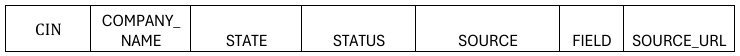

In [33]:
import pandas as pd
import random

## Loading Change Log and Master Dataset

In [34]:
change_log = pd.read_csv('daily_change_log.csv')
master_df = pd.read_csv('mca_master_dataset_updated.csv')

/tmp/ipython-input-595124232.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  master_df = pd.read_csv('mca_master_dataset_updated.csv')


## Selecting Sample of Changed Companies

In [40]:
unique_cins = change_log['CIN'].drop_duplicates()
sample_size = min(75, len(unique_cins))
sample_cins = unique_cins.sample(n=sample_size, random_state=42)

In [41]:
sample_df = master_df[master_df['cin'].isin(sample_cins)]


## Simulating Enrichment Function

In [42]:
def enrich_cin(row):
    base_url = "https://www.zaubacorp.com/company/"
    company_slug = row['companyname'].replace(" ", "-").upper()
    return {
        'CIN': row['cin'],
        'COMPANY_NAME': row['companyname'],
        'STATE': row['state'],
        'STATUS': row['companystatus'],
        'SOURCE': 'ZaubaCorp',
        'FIELD': 'Director Names, Company Type, Address, Industry',
        'SOURCE_URL': f"{base_url}{company_slug}/{row['cin']}"
    }

## Applying Enrichment

In [43]:
enriched_data = [enrich_cin(row) for _, row in sample_df.iterrows()]
enriched_df = pd.DataFrame(enriched_data)
enriched_df.to_csv('mca_enriched_dataset.csv', index=False)
print("Enriched dataset saved as 'mca_enriched_dataset.csv'")

Enriched dataset saved as 'mca_enriched_dataset.csv'


## Validating Output

In [44]:
print(enriched_df.head())
print(f"Total enriched companies: {len(enriched_df)}")

                     CIN                                       COMPANY_NAME  \
0  U60231MH2013PTC247302         GAURAV TRANSPORT SOLUTIONS PRIVATE LIMITED   
1  U72300MH2007PTC168273     BAJAJ INSIGHT AND TECHNOLOGIES PRIVATE LIMITED   
2  U27100MH2003PTC141580  UNIQUE STAR ALLIANCE TOOLS MANUFACTURING PRIVA...   
3  U17110MH1983PTC029304                   ORKAY MAN-MADE TEXTILES PVT.LTD.   
4  U72900TN2019PTC132581              DOCUDIGITAL SOLUTIONS PRIVATE LIMITED   

         STATE      STATUS     SOURCE  \
0  Maharashtra      Active  ZaubaCorp   
1  Maharashtra      Active  ZaubaCorp   
2  Maharashtra      Active  ZaubaCorp   
3  Maharashtra  Strike Off  ZaubaCorp   
4   Tamil Nadu  Strike Off  ZaubaCorp   

                                             FIELD  \
0  Director Names, Company Type, Address, Industry   
1  Director Names, Company Type, Address, Industry   
2  Director Names, Company Type, Address, Industry   
3  Director Names, Company Type, Address, Industry   
4  Direc

# **PHASE 4**: Query Layer
Develop an interface for **interactive data access and visualization**.

**Functional requirements**:
* Build a **Streamlit** or **Flask-based dashboard** with:
  * Search functionality (CIN or Company Name)
  * Filters by Year, State, and Company Status
  * Visualized change history over time
  * Display of enriched company-level information
              
* Include an **optional REST API endpoint** (/search_company) for integration with external applications or testing via Postman.

In [45]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 61.9 MB/s eta 0:00:00


In [79]:
dashboard_code = """
import pandas as pd
import streamlit as st
import plotly.express as px

def generate_daily_summary(change_log_path):
    df = pd.read_csv(change_log_path)

    new_incos = df[df['Change_Type'] == 'New Incorporation'].shape[0]
    removals = df[df['Change_Type'] == 'Deregistered'].shape[0]
    updates = df[df['Change_Type'] == 'Field Update'].shape[0]

    summary = f"📋 Daily Summary\\nNew incorporations: {new_incos}\\nDeregistered: {removals}\\nUpdated records: {updates}"
    return summary


# Load datasets
change_log = pd.read_csv('daily_change_log.csv')
enriched_df = pd.read_csv('mca_enriched_dataset.csv')

st.title("📊 MCA Insights Dashboard")
st.markdown("Explore company changes and enriched metadata")

st.subheader("🧠 AI-Generated Daily Summary")
summary_text = generate_daily_summary("daily_change_log.csv")
st.text(summary_text)

# 🔍 Search
search_input = st.text_input("Search by CIN or Company Name")
if search_input:
    enriched_match = enriched_df[
        enriched_df['COMPANY_NAME'].str.contains(search_input, case=False, na=False) |
        enriched_df['CIN'].str.contains(search_input, case=False, na=False)
    ]
    st.subheader("🔎 Search Results")
    st.dataframe(enriched_match)

# 🧭 Filters
year_filter = st.selectbox("Filter by Year", options=sorted(change_log['Date'].unique()))
state_filter = st.multiselect("Filter by State", options=enriched_df['STATE'].unique(), default=enriched_df['STATE'].unique())
status_filter = st.multiselect("Filter by Status", options=enriched_df['STATUS'].unique(), default=enriched_df['STATUS'].unique())

filtered_df = enriched_df[
    (enriched_df['STATE'].isin(state_filter)) &
    (enriched_df['STATUS'].isin(status_filter))
]

# 📈 Change History
change_counts = change_log.groupby(['Date', 'Change_Type']).size().reset_index(name='Count')
fig = px.bar(change_counts, x='Date', y='Count', color='Change_Type', title='Change History Over Time')
st.plotly_chart(fig)

# 🧠 Enriched Info
st.subheader("📋 Enriched Company Records")
st.dataframe(filtered_df)

# 🔗 Source URLs
st.subheader("🔗 Source Links")
for _, row in filtered_df.iterrows():
    st.markdown(f"[{row['COMPANY_NAME']}]({row['SOURCE_URL']})")
"""


In [80]:
with open("mca_dashboard.py", "w") as f:
    f.write(dashboard_code)

In [81]:
from google.colab import files
files.download("mca_dashboard.py")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
from google.colab import files
files.download("daily_change_log.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [83]:
from google.colab import files
files.download("mca_enriched_dataset.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **PHASE 5**: AI-Powered Features (Enhanced Insight Layer) (Already done in the Streamlit code above)
To provide an **intelligent and interactive user experience**, integrate an AI-powered layer that leverages structured MCA data for discovery and analysis.

**This includes**:
* Automated **AI Summary Generation** for daily change reports.
* A **conversational chatbot interface** that allows users to query and explore
company changes, trends, and insights in natural language.

This layer transforms the system from a static tracker into an **AI-driven insight engine**.

## 1. AI Summary Generator

Automatically generate **concise daily reports** after each data update.
These reports highlight key company-level changes and serve as quick analytical
summaries.

Reports summarize the following:
* Total number of **new incorporations, removals**, and **field updates**
* Notable **status transitions** or variations in company data

**Example Output**:

Daily Summary


New incorporations: 124

Deregistered: 5

Updated records: 42

This summary can be generated automatically and stored as a .txt or .json file, or displayed directly in the dashboard interface.


## 2. Chat with MCA Data
              
Implement a **conversational query layer (Chatbot)** that enables users to interact with the MCA dataset using **natural language questions**.

**Example Queries**:
* “Show new incorporations in Maharashtra.”
* “List all companies in the manufacturing sector with authorized capital above Rs.10
lakh.”
* “How many companies were struck off last month?”
The chatbot may use **rule-based natural language interpretation** or **Retrieval Augmented Generation (RAG)** using an **LLM of choice**.

It translates user questions into structured database queries and returns relevant records or summaries directly through the chat interface.